# Анализ цветов

In [45]:
from skimage.io import imread
image = imread('pic.jpg')
print "Размерность картинки: {}".format(image.shape)

height=image.shape[0]
width=image.shape[1]

# Каждый элемент -- это массив из трех элементов (R, G, B)
# то есть мы работаем с 3D-массивом
print "Первый пиксель: {}".format(image[(0,0)])

Размерность картинки: (474, 713, 3)
Первый пиксель: [  3 125   4]


In [2]:
from skimage import img_as_float

# Нормализуем и отмасштабируем цвета пикселей
fi=img_as_float(image)

In [3]:
print fi.shape
print fi[0][0]

(474, 713, 3)
[ 0.01176471  0.49019608  0.01568627]


In [4]:
# Пример обращения к RGB компонентам пикселей
print fi[0][0][0]
print fi[0][0][1]
print fi[0][0][2]

0.0117647058824
0.490196078431
0.0156862745098


In [5]:
# Линеаризация: преобразование двухмерных координат в одномерные
def to_1d(x,y):
    return y + x * width

# Обратная процедура: получаем двумерные координаты из одномерной
def to_2d(z):
    return (z / width, z % width)

# Test-Driven Development
for x in range(0,height):
    for y in range(0,width):
        assert (x,y) == to_2d(to_1d(x,y)), "({}, {}) => {} => {}".format(x,y,to_1d(x,y),to_2d(to_1d(x,y)))

In [6]:
import numpy as np

# Преобразуем 2D-картинку в одномерный массив
def to_X(pic):
    X=np.zeros((height*width,3))
    for x in range(0,height):
        for y in range(0,width):
            X[to_1d(x,y)]=fi[x,y]

    return X

X=to_X(fi)

In [7]:
# Получили матрицу объект-признак: 
# Каждая строчка соответствует одному пикселю картинки
# Колонки -- RGB-компоненты

# В нашей матрице "потерялась" информация о координатах пикселей,
# точнее, ее можно восстановить их порядкого номера пикселя в таблице,
# но алгоритм машинного обучения не обращает внимания на порядок данных в таблице

print X.shape

print X[0]

(337962, 3)
[ 0.01176471  0.49019608  0.01568627]


In [44]:
# Настроим начальные параметры модели
from sklearn.cluster import KMeans
km=KMeans(init='k-means++', random_state=241, n_clusters=4)
km

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=241, tol=0.0001,
    verbose=0)

In [9]:
# Обучим алгоритм на наших данных
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=241, tol=0.01,
    verbose=0)

In [10]:
# "Центры" кластеров "близких" цветов -- это... "усредненные" цвета близких цветов

# Средних цветов может не быть в начальном наборе данных, но они находятся в том же пространстве цветов

# Центр -- это вычисленная точка,
# она считается так, чтобы квадрат расстояния от каждого элемента кластера до нее было минимальным

# Количество кластеров задается явно для KMeans (n_clusters=1)

print km.cluster_centers_

[[ 0.10777745  0.13829433  0.05432883]
 [ 0.70047306  0.59050741  0.69628518]
 [ 0.83271759  0.53958808  0.07261146]
 [ 0.13441755  0.624454    0.24099885]]


In [11]:
# Модель пометила каждый цвет меткой кластера
print km.labels_.shape
print km.labels_

import pandas
print "Распределение цветов по кластерам: \n{}".format(pandas.DataFrame(km.labels_).stack().value_counts())

(337962,)
[3 3 3 ..., 0 0 0]
Распределение цветов по кластерам: 
3    116018
1     85621
0     85113
2     51210
dtype: int64


In [12]:
###
### Усредним цвета для каждого кластера
###

# Применить функцию f к RGB-компонентам картинки
def f_color(ix_1d,pic,f):
    rgb=pic[to_2d(ix_1d)]
    return (f(rgb,axis=0))


# Восстановим цвета кластеров
def avg_median_colors(pic,km):
    avg_colors=np.zeros((km.n_clusters,3),dtype=int)
    median_colors=np.zeros((km.n_clusters,3),dtype=int)
    cluster_colors=np.zeros((km.n_clusters,3),dtype=int)

    for k in range(0,km.n_clusters):
        # Получим все координаты пикселей, принадлежащих кластеру k
        ix_1d=np.where(km.labels_== k)[0]
        
        # Вычислим средний и медианный цвета для кластера k
        avg_colors[k]=f_color(ix_1d,image,np.average)
        median_colors[k]=f_color(ix_1d,image,np.median)
        
        # Восстановим цвет из центра кластера
        fRGB=km.cluster_centers_[k]
        cluster_colors[k]=fRGB*255

    return (avg_colors, median_colors, cluster_colors)

avg_colors,median_colors,cluster_colors=avg_median_colors(image,km)

print "Средние: \n{}".format(avg_colors)

print "Медианы: \n{}".format(median_colors)

print "Вычисленные центры кластеров: \n{}".format(cluster_colors)

Средние: 
[[ 27  36  13]
 [179 149 177]
 [213 138  18]
 [ 35 159  62]]
Медианы: 
[[  6  28   4]
 [187 180 180]
 [230 150   7]
 [ 21 160  51]]
Вычисленные центры кластеров: 
[[ 27  35  13]
 [178 150 177]
 [212 137  18]
 [ 34 159  61]]


# Картинки

In [13]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
def image_from(colors,labels):
    img=Image.new('RGB',(width,height))
    ip=img.load()
    for x in range(0,height):
        for y in range(0,width):
            # rotate
            ip[y,x]=tuple(colors[labels[to_1d(x,y)]])
    return img

def imshow_near(image_pair, titles=('', ''), figsize=(15, 5), **kwargs):
    ncols=3
    fig, axes = plt.subplots(ncols=ncols, figsize=figsize)
    for ax, img, label in zip(axes.ravel(), image_pair, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)

### PSNR
Общепринятой величиной для оценки потерь при восстановлении изображений является метрика, называемая пиковое отношение сигнал/шум или по-английски PSNR. При этом, чем больше значение PSNR, тем меньше потерь при восстановлении и наоборот. Однако полученное значение не дает гарантию, что зрителю понравится восстановленный образ.

In [37]:
from math import log10

def MSE(pic,colors,labels):
    return np.sum((pic[to_2d(np.array(range(0,len(km.labels_))))]-colors[labels])**2)/(1.*len(labels)*3)

def PSNR(pic,colors,labels):
    return 20*log10(255)-10*log10(MSE(pic,colors,labels))


In [40]:
from datetime import datetime

def test(k):
    start=datetime.now()
    km=KMeans(init='k-means++', random_state=241, n_clusters=k, tol=0.01)
    km.fit(X)
    avg_colors,median_colors,cluster_colors=avg_median_colors(image,km)
    imshow_near(
        (image_from(cluster_colors,km.labels_),
         image_from(avg_colors,km.labels_),
         image_from(median_colors,km.labels_))
        ,
        titles=("cluster (k={}, PSNR={}dB)".format(km.n_clusters, PSNR(image,cluster_colors,km.labels_)),
                "avg (k={}, PSNR={}dB)".format(km.n_clusters, PSNR(image,avg_colors,km.labels_)),
                "median (k={}, PSNR={}dB)".format(km.n_clusters, PSNR(image,median_colors,km.labels_))))
    end=datetime.now()
    print end-start

0:00:02.490915


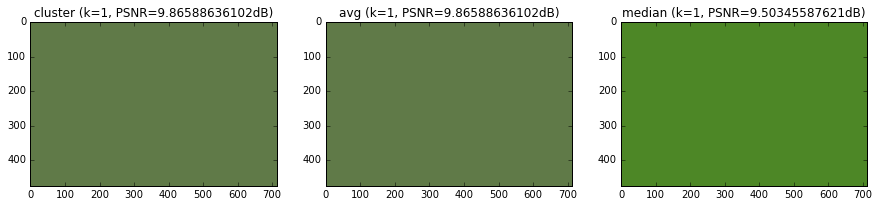

In [41]:
test(1)

0:00:03.113643


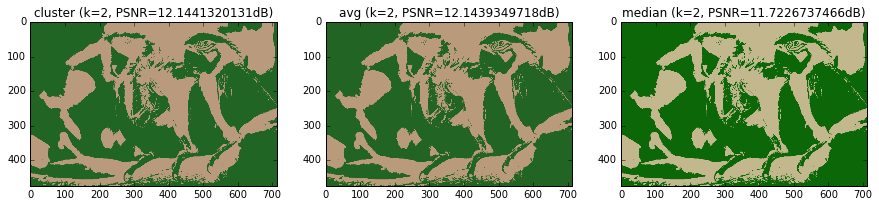

In [42]:
test(2)

0:00:03.445264


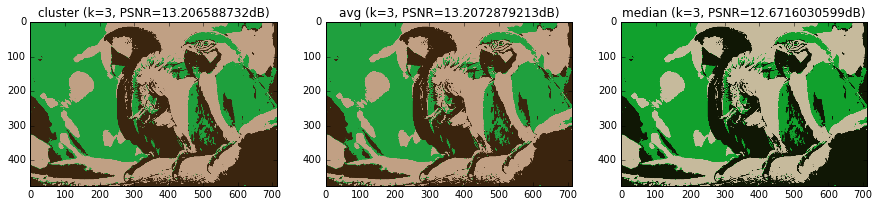

In [43]:
test(3)

0:00:05.684696


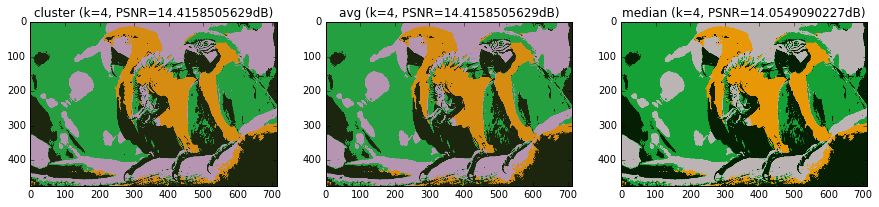

In [20]:
test(4)

0:00:07.381720


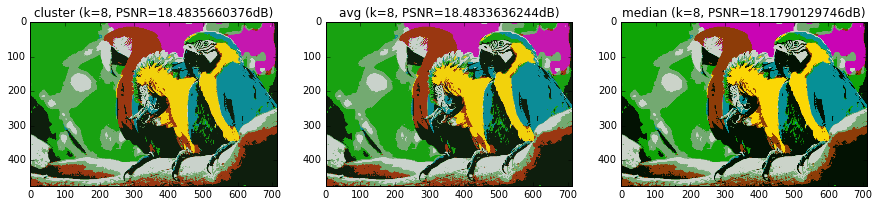

In [21]:
test(8)

0:00:16.712964


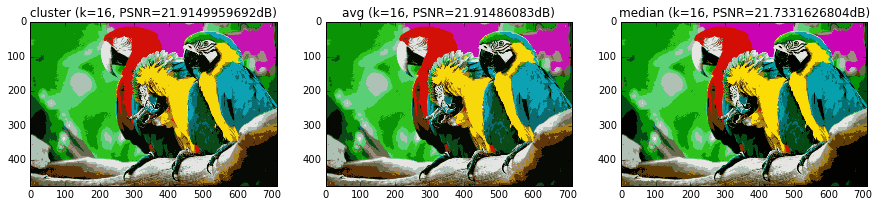

In [22]:
test(16)

0:00:41.312652


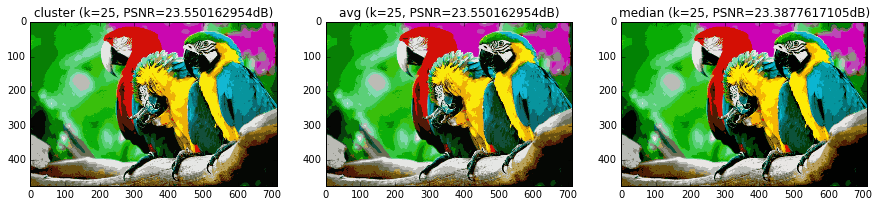

In [23]:
test(25)

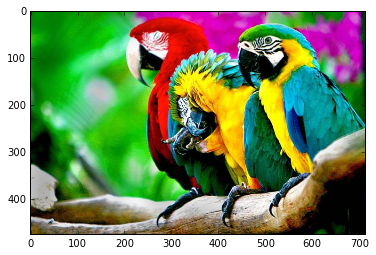

In [46]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('pic.jpg', 'r')
imshow(np.asarray(pil_im))